In [1]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from math import ceil
from random import shuffle
from itertools import chain
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers as opt
import pandas as pd
from transformers import RobertaTokenizer
import os
import transformers
from pathlib import Path
import torch
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, GPT2Tokenizer

c:\Users\Himesh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# print(type(X))

In [3]:
#basePath = r'/home/himesh/TagCoder/pythonNotebook'
basePath = r'C:\Users\Himesh\Documents\thesis\pythonNotebook'
positivePathSuffix = '/Positive'
negativePathSuffix = '/Negative'
tokenizerInPath = basePath + '\\tokenizerIn'
tokenizerOutPath = basePath + '\\tokenizerOut'
train_ratio = 0.7

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
#tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

###try with code bert not just bert

In [5]:
def compute_max(arr, dim="width", z=2):
    mn = np.mean(arr, axis=0)
    sd = np.std(arr, axis=0)
    final_list = [x for x in arr if (x <= mn + z * sd)]  # upper outliers removed
    rmn2 = len(arr) - len(final_list)
    print('{} array size '.format(dim) + str(len(arr)))
    print('min {} '.format(dim) + str(min(arr)))
    print('max {} '.format(dim) + str(max(arr)))
    print('mean {} '.format(dim) + str(np.nanmean(arr)))
    print('standard deviation ' + str(np.std(arr)))
    print('median {} '.format(dim) + str(np.nanmedian(arr)))
    print('number of upper outliers removed ' + str(rmn2))
    print('max {} excluding upper outliers '.format(dim) + str(max(final_list)))
    return max(final_list)

In [6]:
def _get_outlier_threshold(path, z, is_c2v):
    print('Getting outlier threshold via inner method. The path passed is '+path)
    lengths = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.startswith("."):
                continue
            filepath = os.path.join(root, f)
            with open(filepath, "r", errors='ignore') as file:
                #print('Working with file'+ filepath)
                for line in file:
                    input_str = line.replace("\t", " ")
                    if is_c2v:
                        np_arr = np.fromstring(input_str, dtype=np.float, sep=" ")
                    else:
                        np_arr = np.fromstring(input_str, dtype=np.int32, sep=" ")
                    cur_width = len(np_arr)
                    #print('cur_width: '+str(cur_width))
                    lengths.append(cur_width)
    
    #print(' '.join(map(str, lengths)))
    #print(compute_max(lengths,z=z))
    return compute_max(lengths, z=z)


In [7]:
len1 = _get_outlier_threshold((os.path.join(tokenizerOutPath,'ComplexMethod','Positive')),z=1,is_c2v = False)
len2 = _get_outlier_threshold((os.path.join(tokenizerOutPath,'ComplexMethod','Negative')),z=1,is_c2v = False)

if len1 > len2:
    maxLength = len1 
else:
    maxLength = len2

Getting outlier threshold via inner method. The path passed is C:\Users\Himesh\Documents\thesis\pythonNotebook\tokenizerOut\ComplexMethod\Positive
width array size 944
min width 512
max width 2190
mean width 602.8792372881356
standard deviation 201.7674766994313
median width 512.0
number of upper outliers removed 98
max width excluding upper outliers 804
Getting outlier threshold via inner method. The path passed is C:\Users\Himesh\Documents\thesis\pythonNotebook\tokenizerOut\ComplexMethod\Negative
width array size 1708
min width 7
max width 8045
mean width 547.9133489461358
standard deviation 402.91820548792396
median width 512.0
number of upper outliers removed 115
max width excluding upper outliers 949


In [8]:
smellList = ['Multifaceted']
final_text = ""
#maxLength = 0
print(tokenizerInPath)
for smell in smellList:
    smellPath = os.path.join(tokenizerInPath, smell,'Positive',"")
    #print(smellPath)
    
    for file in os.listdir(smellPath):
        #print(os.path.basename(file))
        with open(os.path.join(smellPath, file),"r",encoding='utf-8') as read_file:
            try:
                text = read_file.read()
                tokenized_text = tokenizer.tokenize(text,padding = "max_length")
                input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
                #print(len(input_ids))
                # if len(input_ids) > maxLength:
                #     maxLength = len(input_ids)
                # modint = (len(input_ids)) % 512
                # #print(modint)
                # length = len(input_ids) - modint
            
                # input_ids = input_ids[0:length]
                final_text += ' '.join(map(str, input_ids))+'\n'
            except Exception as e:
                print(e)
                pass
    #Path(os.path.join(tokenizerOutPath,smell,positivePathSuffix, 'tokenizer.tok')).touch(exist_ok=True)        
    with open(os.path.abspath(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok')),'w',errors='ignore') as out_file:
        #out_file.touch(exist_ok=True)
        #print(final_text)
        out_file.write(final_text)
    
smellPath = os.path.join(tokenizerInPath, smell,'Negative',"")
print(smellPath)

for file in os.listdir(smellPath):
    #print(os.path.basename(file))
    with open(os.path.join(smellPath, file),"r",encoding='utf-8') as read_file:
        try:
            text = read_file.read()
            tokenized_text = tokenizer.tokenize(text)#,padding = "max_length")
            input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
            #print(len(input_ids))
            # if len(input_ids) > maxLength:
            #     maxLength = len(input_ids)
            
            # modint = (len(input_ids)) % 512
            # #print(modint)
            # length = len(input_ids) - modint
           
            # input_ids = input_ids[0:length]
           
            final_text += ' '.join(map(str, input_ids))+'\n'
        except Exception as e:
            print(e)
            
            pass
#Path(os.path.join(tokenizerOutPath,smell,positivePathSuffix, 'tokenizer.tok')).touch(exist_ok=True)        
with open(os.path.abspath(os.path.join(tokenizerOutPath,smell,'Negative', 'tokenizer.tok')),'w',errors='ignore') as out_file:
    #out_file.touch(exist_ok=True)
    #print(final_text)
    out_file.write(final_text)


C:\Users\Himesh\Documents\thesis\pythonNotebook\tokenizerIn


Token indices sequence length is longer than the specified maximum sequence length for this model (758 > 512). Running this sequence through the model will result in indexing errors


C:\Users\Himesh\Documents\thesis\pythonNotebook\tokenizerIn\LongParameter\Negative\


In [9]:
X = []
Y = []

num_lines_pos = sum(1 for line in open(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok'),"r"))
with open(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok'),"r") as read_file:
    #text = read_file.read()
  
    #text = text.replace('\n', ' ')
    #text = text.replace('\r', ' ')
    #print(text)
    #posInput = np.fromstring(text, sep=" ").tolist()
    #print(len(posInput))
    for line in read_file:
        
        if line == '\n':
            continue 
        arr = np.fromstring(line, dtype=np.int32, sep=" ",count=maxLength)
        arr_size = len(arr)
        if arr_size <= maxLength:
                    arr[arr_size:maxLength] = 0
        X.append(arr)
        Y = Y +[1]
print(len(X))
with open(os.path.join(tokenizerOutPath,smell,'Negative', 'tokenizer.tok'),"r") as read_file:
    # text = read_file.read()
  
    # text = text.replace('\n', ' ')
    # text = text.replace('\r', ' ')
    # #print(text)
    # negInput = np.fromstring(text, dtype=np.int32, sep=" ").tolist()

    for line in read_file:
        if line == '\n':
            continue
        arr = np.fromstring(line, dtype=np.int32, sep=" ",count=maxLength)
        arr_size = len(arr)
        if arr_size <= maxLength:
                    arr[arr_size:maxLength] = 0
        X.append(arr)
        Y = Y +[0]
print(len(X))
print((maxLength))

X = np.asarray(X)

print(type(X))
n_inputs = X.shape[1]

637
1787
949
<class 'numpy.ndarray'>


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 1 - train_ratio, random_state=1)
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
print(X_train[0:5])

[[0.0044555  0.00445098 0.00410876 ... 0.50178786 0.53752275 0.43889112]
 [0.0050867  0.12687231 0.63349887 ... 0.50178797 0.53752275 0.43889072]
 [0.0050867  0.12687231 0.63349887 ... 0.58249252 0.53752288 0.43889072]
 [0.0050867  0.12687231 0.63349887 ... 0.50178751 0.53752275 0.43889072]
 [0.05457988 0.47149437 0.47661581 ... 0.50178751 0.53752275 0.43889072]]


Epoch 1/200
79/79 [==============================] - 16s 146ms/step - loss: 0.0870 - accuracy: 0.0088 - val_loss: 39329.4805 - val_accuracy: 0.0000e+00
Epoch 2/200
79/79 [==============================] - 11s 142ms/step - loss: 0.0362 - accuracy: 0.0216 - val_loss: 38463.1133 - val_accuracy: 0.0000e+00
Epoch 3/200
79/79 [==============================] - 11s 146ms/step - loss: 0.0292 - accuracy: 0.0320 - val_loss: 37817.2148 - val_accuracy: 0.1080
Epoch 4/200
79/79 [==============================] - 12s 150ms/step - loss: 0.0252 - accuracy: 0.0432 - val_loss: 54311.2695 - val_accuracy: 0.0000e+00
Epoch 5/200
79/79 [==============================] - 11s 145ms/step - loss: 0.0248 - accuracy: 0.0456 - val_loss: 48349.6406 - val_accuracy: 0.0149
Epoch 6/200
79/79 [==============================] - 12s 148ms/step - loss: 0.0179 - accuracy: 0.0480 - val_loss: 44792.4062 - val_accuracy: 0.1117
Epoch 7/200
79/79 [==============================] - 11s 144ms/step - loss: 0.0195 - accuracy: 0.038

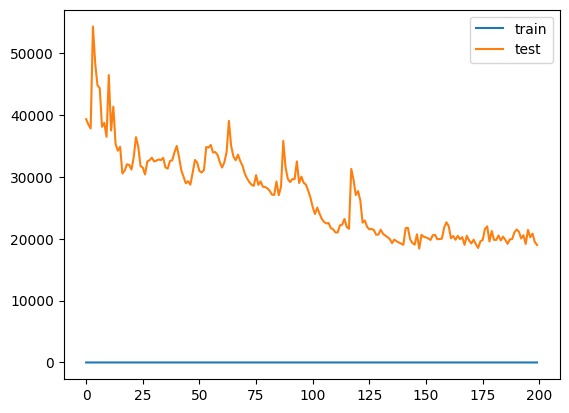

In [11]:
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=1, validation_data=(X_test,X_test),shuffle=True)
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
# plot_model(encoder, 'encoder_compress.png', show_shapes=True)
encoder.save('encoder.h5')

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score


In [13]:
encoder = load_model('encoder.h5')
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

model = LogisticRegression()
model.fit(X_train_encode, y_train)

yhat = model.predict(X_test_encode)
print(len(yhat))
print(yhat)
#yhat = yhat.pop()
acc = accuracy_score(y_test, yhat)
print(acc)
print(f1_score(y_test, yhat))


17/17 [==============================] - 0s 12ms/step
537
[0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1
 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0
 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

c:\Users\Himesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

[0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1
 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0
 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 1 1 0 1 

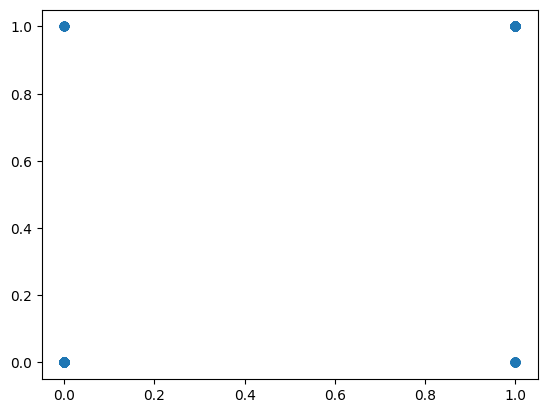

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       353
           1       0.88      0.72      0.79       184

    accuracy                           0.87       537
   macro avg       0.87      0.83      0.85       537
weighted avg       0.87      0.87      0.87       537

0.7916666666666667


In [16]:
print(yhat)
#print(y_test[1])
y_pred_bool = pd.cut(x=yhat.flatten(),bins=[0,0.4,1],labels=[0,1])
#y_pred_bool =  torch.round(torch.tensor(yhat))
#y_pred_bool = y_pred_bool.numpy()
#print(collections.Counter(y_pred_bool.tolist()))
plt.scatter(y_test,yhat)
plt.show()
#print(pd.DataFrame(y_pred_bool).describe())
#print("Accuracy: %.2f%%" % (scores[1]*100)) 
print(classification_report(y_test, yhat))
acc = accuracy_score( yhat,y_test)
# print(acc)
print(f1_score(y_test, yhat))

In [17]:
pip install seaborn


  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


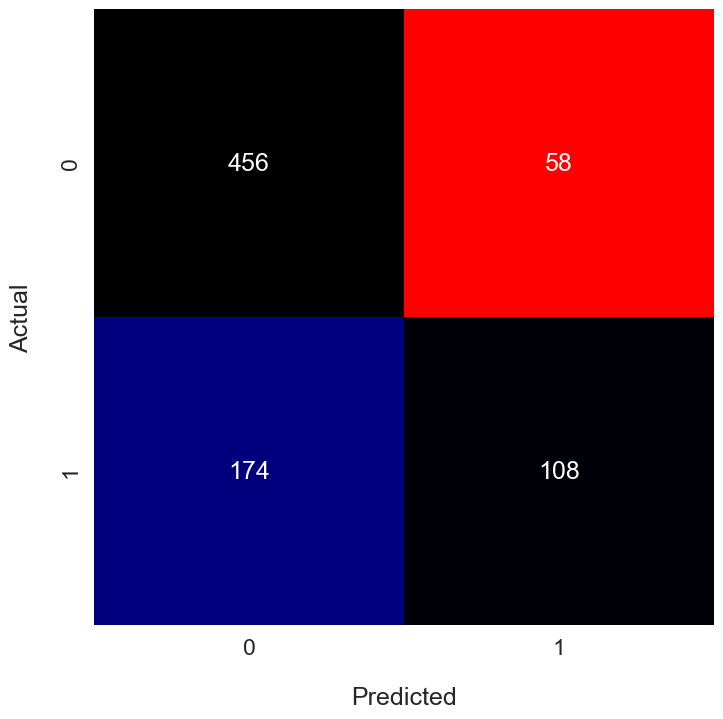

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    confusion_matrix(y_test, yhat), # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()
